## Importing Libaries

In [1]:
import os
import pandas as pd
import numpy as np
import time
from alpha_vantage.fundamentaldata import FundamentalData
from alpha_vantage.timeseries import TimeSeries
import requests
from datetime import datetime
import finnhub
import os


FINNHUB_API_KEY = os.environ["FIN_KEY"]
AV_KEY = os.environ["AV_KEY"]
av = FundamentalData(key=AV_KEY, output_format="pandas")
ts = TimeSeries(key=AV_KEY, output_format="pandas")


finnhub_client = finnhub.Client(api_key=FINNHUB_API_KEY)


# Where to cache raw data
os.makedirs("agent1_raw_cache", exist_ok=True)


## Gathering the data

In [2]:
def get_ticker_data(ticker, company_name, start_year=2018):
    try:
        out_path = f"agent1_raw_cache/{ticker}_monthly.parquet"
        if os.path.exists(out_path):
            print(f"{ticker}: already cached")
            return pd.read_parquet(out_path)


        # Fetching quarterly financials
        inc, _ = av.get_income_statement_quarterly(ticker)
        bal, _ = av.get_balance_sheet_quarterly(ticker)
        if inc.empty or bal.empty:
            print(f"{ticker}: financials missing")
            return pd.DataFrame()


        inc = inc.set_index("fiscalDateEnding").sort_index()
        bal = bal.set_index("fiscalDateEnding").reindex(inc.index)
        inc.index = pd.to_datetime(inc.index)
        bal.index = pd.to_datetime(bal.index)


        inc = inc[inc.index >= pd.to_datetime(f"{start_year}-01-01")]
        bal = bal[bal.index >= pd.to_datetime(f"{start_year}-01-01")]


        # Fetching monthly price data
        px, _ = ts.get_monthly_adjusted(ticker)
        px = pd.to_numeric(px["5. adjusted close"], errors="coerce")
        price_df = px.to_frame("Close")
        price_df.index = pd.to_datetime(price_df.index)
        price_df = price_df.sort_index()
        price_df = price_df[price_df.index >= pd.to_datetime(f"{start_year}-01-01")]


        # Estimating Market Cap from shares outstanding
        try:
            overview, _ = av.get_company_overview(ticker)
            shares_out = pd.to_numeric(overview.iloc[0].get("SharesOutstanding", np.nan), errors="coerce")
        except Exception as e:
            print(f"{ticker}: overview error: {e}")
            return pd.DataFrame()


        if np.isnan(shares_out):
            print(f"{ticker}: missing shares_out")
            return pd.DataFrame()


        price_df["Market_Cap"] = price_df["Close"] * shares_out
        price_df["Market_Cap_t+1M"] = price_df["Market_Cap"].shift(-1)
        price_df["Price_Change_1M"] = price_df["Close"].pct_change()


        # Carring forward quarterly data to monthly
        monthly = price_df.copy()
        for colname, source_df in {
            "Total_Revenue": inc.get("totalRevenue"),
            "Net_Income": inc.get("netIncome"),
            "EPS": inc.get("eps"),
            "Gross_Profit": inc.get("grossProfit"),
            "EBIT": inc.get("ebit"),
            "R&D_Expense": inc.get("researchAndDevelopment"),
            "Operating_Income": inc.get("operatingIncome"),
            "Total_Debt": bal.get("totalLiabilities"),
            "Total_Assets": bal.get("totalAssets"),
            "Cash": bal.get("cashAndCashEquivalentsAtCarryingValue"),
            "Short_Term_Investments": bal.get("shortTermInvestments"),
            "Current_Assets": bal.get("totalCurrentAssets"),
            "Current_Liabilities": bal.get("totalCurrentLiabilities"),
            "Shareholder_Equity": bal.get("totalShareholderEquity")
        }.items():
            if isinstance(source_df, pd.Series):
                source_df.index = pd.to_datetime(source_df.index)
                series = pd.to_numeric(source_df, errors="coerce")
                monthly[colname] = series.reindex(monthly.index, method="ffill")
            else:
                monthly[colname] = np.nan


        # Enforcing float dtype properly
        key_cols = ["EPS", "Total_Revenue", "Total_Debt"]
        for col in key_cols:
            if col not in monthly.columns:
                monthly[col] = np.nan
            monthly[col] = pd.to_numeric(monthly[col], errors="coerce")
            if not np.issubdtype(monthly[col].dtype, np.number):
                monthly[col] = monthly[col].astype(float)


        # All numeric columns
        numeric_cols = [
            "Total_Revenue", "Net_Income", "EPS", "Gross_Profit", "EBIT",
            "R&D_Expense", "Operating_Income", "Total_Debt", "Total_Assets",
            "Cash", "Short_Term_Investments", "Current_Assets", "Current_Liabilities",
            "Shareholder_Equity"
        ]
        for col in numeric_cols:
            monthly[col] = pd.to_numeric(monthly[col], errors="coerce")


        # Engineered features
        monthly["Gross_Margin"] = monthly["Gross_Profit"] / monthly["Total_Revenue"]
        monthly["Net_Margin"] = monthly["Net_Income"] / monthly["Total_Revenue"]
        monthly["Debt_to_Equity"] = monthly["Total_Debt"] / monthly["Shareholder_Equity"]
        monthly["RD_to_Revenue"] = monthly["R&D_Expense"] / monthly["Total_Revenue"]
        monthly["Quick_Ratio"] = (monthly["Cash"] + monthly["Short_Term_Investments"]) / monthly["Current_Liabilities"]


        # Adding meta & time-based features
        monthly.index = pd.to_datetime(monthly.index, errors="coerce")
        monthly["Month"] = monthly.index
        monthly["Company"] = company_name
        

        # Recency weight: 0 (oldest) → 1 (most recent)
        monthly["Recency_Weight"] = (
            (monthly["Month"] - monthly["Month"].min()).dt.days /
            (monthly["Month"].max() - monthly["Month"].min()).days
        ).fillna(0)
        

        # 1-month %-change features
        monthly["Revenue_Growth_1M"] = (
            pd.to_numeric(monthly["Total_Revenue"], errors="coerce")
              .pct_change(fill_method=None)
        )
        monthly["EPS_Growth_1M"] = (
            pd.to_numeric(monthly["EPS"], errors="coerce")
              .pct_change(fill_method=None)
        )
        monthly["Debt_Change_1M"] = (
            pd.to_numeric(monthly["Total_Debt"], errors="coerce")
              .pct_change(fill_method=None)
        )
        

        # Final cleanup
        monthly = monthly.dropna(subset=["Market_Cap_t+1M"])
        

        # Row-level sample weight
        monthly["Row_Weight"] = (
            monthly["Recency_Weight"] *
            monthly["Company"].map(monthly["Company"].value_counts())
        )
        

        # Clipping numeric columns to remove extreme outliers
        num_cols = monthly.select_dtypes(include=[np.number]).columns
        q_low = monthly[num_cols].quantile(0.01)
        q_high = monthly[num_cols].quantile(0.99)
        monthly[num_cols] = monthly[num_cols].clip(lower=q_low, upper=q_high, axis=1)
        

        monthly.to_parquet(out_path)
        print(f"{ticker}: saved ({len(monthly)} rows)")
        return monthly




    except Exception as e:
        print(f"{ticker} failed: {e}")
        return pd.DataFrame()


## Creating the DF

In [ ]:
tickers = {
    "TSLA": "Tesla",
    "F": "Ford",
    "GM": "GM",
    "RIVN": "Rivian",
    "LCID": "Lucid",
    "TM": "Toyota",
    "HMC": "Honda",
    "NIO": "NIO",
    "XPEV": "XPeng",
    "STLA": "Stellantis",
    "PSNY": "Polestar",
    "LI": "Li Auto",
    "RACE": "Ferrari",
    "LCII": "LCI Industries",
    "ALV": "Autoliv"
}


# Gathering data
all_data = []
for tkr, name in tickers.items():
    df = get_ticker_data(tkr, name)
    if not df.empty:
        all_data.append(df)


# Saving final combined dataset
combined = pd.concat(all_data).reset_index(drop=True)
combined.to_parquet("agent1_combined_training_data.parquet")
print("Final combined rows:", combined.shape)


In [3]:
# Loading data and ordering
df = pd.read_parquet("agent1_combined_training_data.parquet")
df["Month"] = pd.to_datetime(df["Month"])
df = df.sort_values(["Company", "Month"]).reset_index(drop=True)


# Core Features
df["Cash_to_Debt"] = df["Cash"] / df["Total_Debt"].replace(0, np.nan)
df["Debt_Ratio"] = df["Total_Debt"] / df["Total_Assets"]
df["Asset_Turnover"] = df["Total_Revenue"] / df["Total_Assets"]


grp = df.groupby("Company", group_keys=False)
df["Revenue_pctchg"] = grp["Total_Revenue"].pct_change(fill_method=None)
df["EPS_pctchg"] = grp["EPS"].pct_change(fill_method=None)
df["Income_Growth"] = grp["Net_Income"].pct_change(fill_method=None)


# Adding rolling vols if they exist in the parquet
for win in (3, 6):
    col = f"Volatility_{win}M"
    if col not in df.columns:
        df[col] = (
            grp["Close"].rolling(win).std()
               .reset_index(level=0, drop=True)
        )


df["Price_Mom_3M"] = grp["Close"].pct_change(periods=3, fill_method=None)


# Target
df = df.rename(columns={"Market_Cap_t+1M": "MarketCap_NextM"})
df["Target_Log"] = np.log1p(df["MarketCap_NextM"])


# one-hot companies
df = pd.concat([df, pd.get_dummies(df["Company"], prefix="Company")], axis=1)


# Assembling feature list
base_feats = [
    "Total_Revenue", "Net_Income", "Total_Debt", "Total_Assets",
    "Cash_to_Debt", "Debt_Ratio", "Asset_Turnover",
    "Gross_Margin", "Net_Margin", "RD_to_Revenue", "Quick_Ratio",
    "Revenue_pctchg", "EPS_pctchg", "Income_Growth",
    "Price_Change_1M", "Price_Mom_3M", "Volatility_3M", "Volatility_6M",
    "Revenue_Growth_1M", "EPS_Growth_1M", "Debt_Change_1M",
    "Recency_Weight", "Row_Weight"
]
ohe_feats = [c for c in df.columns if c.startswith("Company_")]
features = [f for f in base_feats if f in df.columns] + ohe_feats


# 3. Missing values
na_frac = df[features + ["Target_Log"]].isna().mean().sort_values(ascending=False)
print("\nTop missing-rate columns:\n", na_frac.head(10))


# Choices
FILL_ZERO = ["Revenue_pctchg", "EPS_pctchg", "Income_Growth", "Price_Mom_3M"]
DROP_THRESH = 0.70  # dropping feature if > 70 % NA


# fill safe growth / pct-change columns
df[FILL_ZERO] = df[FILL_ZERO].fillna(0)


# dropping high-missing features from the list
bad_feats = na_frac[na_frac > DROP_THRESH].index.tolist()
print("\nDropping high-NA features:", bad_feats)
features = [f for f in features if f not in bad_feats]


df_clean = (
    df.replace([np.inf, -np.inf], np.nan)
      .dropna(subset=features + ["Target_Log"])
      .reset_index(drop=True)
)


print(f"\nModelling frame: {df_clean.shape}")
print(df_clean.head())



Top missing-rate columns:
 EPS_Growth_1M        1.000000
EPS_pctchg           1.000000
Quick_Ratio          0.215909
RD_to_Revenue        0.200175
Volatility_6M        0.065559
Debt_Change_1M       0.047203
Revenue_pctchg       0.040210
Income_Growth        0.040210
Revenue_Growth_1M    0.040210
Price_Mom_3M         0.039336
dtype: float64

Dropping high-NA features: ['EPS_Growth_1M', 'EPS_pctchg']

Modelling frame: (722, 55)
     Close    Market_Cap  MarketCap_NextM  Price_Change_1M  Total_Revenue  \
0  86.4197  6.637638e+09     6.591039e+09        -0.032101   2.812800e+09   
1  85.8130  6.591039e+09     5.769220e+09        -0.007020   2.211500e+09   
2  75.1132  5.769220e+09     5.613155e+09        -0.124687   2.211500e+09   
3  73.0813  5.613155e+09     5.396867e+09        -0.027051   2.211500e+09   
4  70.2653  5.396867e+09     5.604300e+09        -0.038532   2.033000e+09   

    Net_Income  EPS  Gross_Profit         EBIT  R&D_Expense  ...  \
0  126700000.0  NaN   579200000.0  210

## Train test split

In [4]:
# Making sure Month is datetime
df_clean["Month"] = pd.to_datetime(df_clean["Month"], errors="coerce")


# Cut-off date = newest 15 % for validation
cutoff = df_clean["Month"].quantile(0.85)


train_df = df_clean[df_clean["Month"] <= cutoff]
val_df = df_clean[df_clean["Month"] >  cutoff]


print(f"Train rows: {train_df.shape[0]}  |  Val rows: {val_df.shape[0]}")


Train rows: 620   |  Val rows: 102


## Training the Model

In [6]:
from autogluon.tabular import TabularPredictor


LABEL = "Target_Log"
SAVE_DIR = "agent1_model"


predictor = (
    TabularPredictor(
        label = LABEL,
        path = SAVE_DIR,
        problem_type = "regression",
        eval_metric = "mean_absolute_error",
    )
    .fit(
        train_data = train_df[features + [LABEL]],
        tuning_data = val_df[features + [LABEL]],
        use_bag_holdout = True,
        presets = "high_quality",
        num_bag_folds = 5,
        num_bag_sets = 3,
        num_stack_levels = 1,
        time_limit = 3600,
        verbosity = 3,
        dynamic_stacking = False,
    )
)


Verbosity: 3 (Detailed Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.16
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          28
GPU Count:          1
Memory Avail:       30.37 GB / 47.82 GB (63.5%)
Disk Space Avail:   391.25 GB / 952.26 GB (41.1%)
Presets specified: ['high_quality']
============ fit kwarg info ============
User Specified kwargs:
{'auto_stack': True,
 'num_bag_folds': 5,
 'num_bag_sets': 3,
 'num_stack_levels': 1,
 'refit_full': True,
 'save_bag_folds': False,
 'set_best_to_refit_full': True,
 'use_bag_holdout': True,
 'verbosity': 3}
Full kwargs:
{'_feature_generator_kwargs': None,
 '_save_bag_folds': None,
 'ag_args': None,
 'ag_args_ensemble': None,
 'ag_args_fit': None,
 'auto_stack': True,
 'calibrate': 'auto',
 'delay_bag_sets': False,
 'ds_args': {'clean_up_fits': True,
             'detection_time_frac': 0.25,
             'enable_callbacks': Fal

0:	learn: 0.8533363	total: 142ms	remaining: 6m 24s
20:	learn: 0.4934285	total: 190ms	remaining: 24.4s
40:	learn: 0.3210555	total: 222ms	remaining: 14.4s
60:	learn: 0.2369649	total: 254ms	remaining: 11.1s
80:	learn: 0.1918432	total: 290ms	remaining: 9.44s
100:	learn: 0.1643354	total: 323ms	remaining: 8.36s
120:	learn: 0.1449013	total: 357ms	remaining: 7.64s
140:	learn: 0.1304694	total: 389ms	remaining: 7.1s
160:	learn: 0.1204466	total: 423ms	remaining: 6.71s
180:	learn: 0.1120823	total: 455ms	remaining: 6.37s
200:	learn: 0.1040269	total: 488ms	remaining: 6.1s
220:	learn: 0.0978477	total: 521ms	remaining: 5.88s
240:	learn: 0.0923825	total: 556ms	remaining: 5.7s
260:	learn: 0.0882296	total: 589ms	remaining: 5.53s
280:	learn: 0.0837581	total: 622ms	remaining: 5.38s
300:	learn: 0.0798432	total: 660ms	remaining: 5.29s
320:	learn: 0.0759971	total: 696ms	remaining: 5.18s
340:	learn: 0.0726087	total: 729ms	remaining: 5.07s
360:	learn: 0.0699158	total: 762ms	remaining: 4.97s
380:	learn: 0.067282

Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_BAG_L1_FULL\model.pkl
	8.17s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\ExtraTreesMSE_BAG_L1\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\ExtraTreesMSE_BAG_L1\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\ExtraTreesMSE_BAG_L1\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\ExtraTreesMSE_BAG_L1\utils\model_template.pkl
Fitting 1 L1 models, fit_strategy="sequential" ...
Fitting model: ExtraTreesMSE_BAG_L1_FULL ...
	Fitting ExtraTreesMSE_BAG_L1_FULL with 'num_gpus': 0, 'num_cpus': 28
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\Extr

2700:	learn: 0.0042438	total: 4.96s	remaining: 22.1ms
2712:	learn: 0.0041962	total: 4.99s	remaining: 0us


Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\ExtraTreesMSE_BAG_L1_FULL\model.pkl
	0.54s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_BAG_L1\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_BAG_L1\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_BAG_L1\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_BAG_L1\utils\model_template.pkl
Fitting 1 L1 models, fit_strategy="sequential" ...
Fitting model: NeuralNetFastAI_BAG_L1_FULL ...
	Fitting NeuralNetFastAI_BAG_L1_FULL with 'num_gpus': 0, 'num_cpus': 28
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_

0:	learn: 0.8426190	total: 2.58ms	remaining: 4.37s
20:	learn: 0.4082376	total: 35.3ms	remaining: 2.81s
40:	learn: 0.2442742	total: 67.4ms	remaining: 2.71s
60:	learn: 0.1797019	total: 98.6ms	remaining: 2.63s
80:	learn: 0.1502606	total: 131ms	remaining: 2.6s
100:	learn: 0.1311553	total: 162ms	remaining: 2.56s
120:	learn: 0.1186463	total: 193ms	remaining: 2.5s
140:	learn: 0.1096964	total: 225ms	remaining: 2.47s
160:	learn: 0.0992250	total: 258ms	remaining: 2.45s
180:	learn: 0.0915243	total: 290ms	remaining: 2.42s
200:	learn: 0.0840983	total: 322ms	remaining: 2.38s
220:	learn: 0.0786622	total: 353ms	remaining: 2.35s
240:	learn: 0.0746853	total: 386ms	remaining: 2.32s
260:	learn: 0.0701947	total: 418ms	remaining: 2.29s
280:	learn: 0.0658258	total: 450ms	remaining: 2.26s
300:	learn: 0.0620970	total: 483ms	remaining: 2.23s
320:	learn: 0.0587338	total: 516ms	remaining: 2.2s
340:	learn: 0.0557915	total: 549ms	remaining: 2.17s
360:	learn: 0.0531904	total: 580ms	remaining: 2.14s
380:	learn: 0.050

Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r177_BAG_L1_FULL\model.pkl


1640:	learn: 0.0047673	total: 2.84s	remaining: 84.9ms
1660:	learn: 0.0046097	total: 2.89s	remaining: 50.4ms
1680:	learn: 0.0044785	total: 2.92s	remaining: 15.6ms
1689:	learn: 0.0044068	total: 2.94s	remaining: 0us


	4.0s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetTorch_r79_BAG_L1\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetTorch_r79_BAG_L1\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetTorch_r79_BAG_L1\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetTorch_r79_BAG_L1\utils\model_template.pkl
Fitting 1 L1 models, fit_strategy="sequential" ...
Fitting model: NeuralNetTorch_r79_BAG_L1_FULL ...
	Fitting NeuralNetTorch_r79_BAG_L1_FULL with 'num_gpus': 0, 'num_cpus': 28
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetTorch_r79_BAG_L1_FULL\utils\model_template.pkl
Loading: C:\Users\bhall\Documents

0:	learn: 0.8603099	total: 16.9ms	remaining: 1m 10s
20:	learn: 0.5608678	total: 166ms	remaining: 32.7s
40:	learn: 0.3814563	total: 324ms	remaining: 32.6s
60:	learn: 0.2691198	total: 481ms	remaining: 32.4s
80:	learn: 0.2005601	total: 640ms	remaining: 32.3s
100:	learn: 0.1566465	total: 812ms	remaining: 32.7s
120:	learn: 0.1314020	total: 967ms	remaining: 32.4s
140:	learn: 0.1122501	total: 1.13s	remaining: 32.3s
160:	learn: 0.0986358	total: 1.3s	remaining: 32.4s
180:	learn: 0.0886304	total: 1.48s	remaining: 32.7s
200:	learn: 0.0815748	total: 1.65s	remaining: 32.5s
220:	learn: 0.0744174	total: 1.81s	remaining: 32.4s
240:	learn: 0.0687230	total: 1.98s	remaining: 32.2s
260:	learn: 0.0633966	total: 2.14s	remaining: 32.1s
280:	learn: 0.0597195	total: 2.31s	remaining: 31.9s
300:	learn: 0.0567635	total: 2.48s	remaining: 31.9s
320:	learn: 0.0540127	total: 2.65s	remaining: 31.8s
340:	learn: 0.0512173	total: 2.85s	remaining: 32s
360:	learn: 0.0484837	total: 3.04s	remaining: 32.1s
380:	learn: 0.04640

Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r9_BAG_L1_FULL\model.pkl
	36.59s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\LightGBM_r96_BAG_L1\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\LightGBM_r96_BAG_L1\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\LightGBM_r96_BAG_L1\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\LightGBM_r96_BAG_L1\utils\model_template.pkl
Fitting 1 L1 models, fit_strategy="sequential" ...
Fitting model: LightGBM_r96_BAG_L1_FULL ...
	Fitting LightGBM_r96_BAG_L1_FULL with 'num_gpus': 0, 'num_cpus': 28
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\LightG

0:	learn: 0.8531868	total: 1.06ms	remaining: 3.66s
20:	learn: 0.5287055	total: 25.6ms	remaining: 4.17s
40:	learn: 0.3851090	total: 43.6ms	remaining: 3.61s
60:	learn: 0.3022984	total: 60.5ms	remaining: 3.35s
80:	learn: 0.2591945	total: 77.6ms	remaining: 3.22s
100:	learn: 0.2262848	total: 93.7ms	remaining: 3.1s
120:	learn: 0.2042454	total: 109ms	remaining: 2.98s
140:	learn: 0.1848657	total: 124ms	remaining: 2.9s
160:	learn: 0.1675228	total: 139ms	remaining: 2.84s
180:	learn: 0.1558570	total: 155ms	remaining: 2.78s
200:	learn: 0.1475935	total: 170ms	remaining: 2.75s
220:	learn: 0.1400519	total: 187ms	remaining: 2.72s
240:	learn: 0.1332741	total: 202ms	remaining: 2.68s
260:	learn: 0.1273284	total: 217ms	remaining: 2.64s
280:	learn: 0.1210882	total: 233ms	remaining: 2.62s
300:	learn: 0.1160357	total: 249ms	remaining: 2.6s
320:	learn: 0.1122442	total: 264ms	remaining: 2.56s
340:	learn: 0.1090750	total: 280ms	remaining: 2.54s
360:	learn: 0.1053842	total: 296ms	remaining: 2.52s
380:	learn: 0.1

Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r137_BAG_L1_FULL\model.pkl
	7.27s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r102_BAG_L1\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r102_BAG_L1\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r102_BAG_L1\utils\model_template.pkl


3400:	learn: 0.0152441	total: 3.08s	remaining: 33.5ms
3420:	learn: 0.0151492	total: 3.1s	remaining: 15.4ms
3437:	learn: 0.0150798	total: 3.12s	remaining: 0us


Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r102_BAG_L1\utils\model_template.pkl
Fitting 1 L1 models, fit_strategy="sequential" ...
Fitting model: NeuralNetFastAI_r102_BAG_L1_FULL ...
	Fitting NeuralNetFastAI_r102_BAG_L1_FULL with 'num_gpus': 0, 'num_cpus': 28
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r102_BAG_L1_FULL\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r102_BAG_L1_FULL\utils\model_template.pkl
Fitting Neural Network with parameters {'layers': [200, 100], 'emb_drop': 0.05070411322605811, 'ps': 0.10393466140748028, 'bs': 2048, 'lr': 0.08974235041576624, 'epochs': 29, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0, 'best_epoch': 26}...
Using 0/0 categorical features
Using 36 cont features
TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=

0:	learn: 0.8707031	total: 10.9ms	remaining: 59.5s
20:	learn: 0.7046585	total: 109ms	remaining: 28.2s
40:	learn: 0.5767751	total: 198ms	remaining: 26.1s
60:	learn: 0.4803090	total: 282ms	remaining: 24.9s
80:	learn: 0.4054766	total: 367ms	remaining: 24.3s
100:	learn: 0.3456875	total: 453ms	remaining: 24s
120:	learn: 0.2994571	total: 540ms	remaining: 23.8s
140:	learn: 0.2628537	total: 627ms	remaining: 23.6s
160:	learn: 0.2312440	total: 716ms	remaining: 23.5s
180:	learn: 0.2066625	total: 805ms	remaining: 23.4s
200:	learn: 0.1880862	total: 892ms	remaining: 23.2s
220:	learn: 0.1729087	total: 977ms	remaining: 23.1s
240:	learn: 0.1610690	total: 1.06s	remaining: 22.9s
260:	learn: 0.1507257	total: 1.15s	remaining: 22.8s
280:	learn: 0.1422723	total: 1.23s	remaining: 22.6s
300:	learn: 0.1346367	total: 1.31s	remaining: 22.5s
320:	learn: 0.1279061	total: 1.4s	remaining: 22.4s
340:	learn: 0.1224581	total: 1.49s	remaining: 22.3s
360:	learn: 0.1177181	total: 1.58s	remaining: 22.3s
380:	learn: 0.113535

Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r13_BAG_L1_FULL\model.pkl
	39.14s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\RandomForest_r195_BAG_L1\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\RandomForest_r195_BAG_L1\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\RandomForest_r195_BAG_L1\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\RandomForest_r195_BAG_L1\utils\model_template.pkl
Fitting 1 L1 models, fit_strategy="sequential" ...
Fitting model: RandomForest_r195_BAG_L1_FULL ...
	Fitting RandomForest_r195_BAG_L1_FULL with 'num_gpus': 0, 'num_cpus': 28
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Disserta

0:	learn: 0.8375565	total: 2.2ms	remaining: 2.33s
20:	learn: 0.4063083	total: 35ms	remaining: 1.72s
40:	learn: 0.2601281	total: 67.1ms	remaining: 1.66s
60:	learn: 0.1972506	total: 97.5ms	remaining: 1.59s
80:	learn: 0.1628558	total: 126ms	remaining: 1.52s
100:	learn: 0.1384266	total: 156ms	remaining: 1.47s
120:	learn: 0.1255299	total: 186ms	remaining: 1.44s
140:	learn: 0.1136494	total: 218ms	remaining: 1.41s
160:	learn: 0.1021393	total: 249ms	remaining: 1.39s
180:	learn: 0.0954218	total: 279ms	remaining: 1.35s
200:	learn: 0.0893921	total: 310ms	remaining: 1.32s
220:	learn: 0.0848702	total: 340ms	remaining: 1.28s
240:	learn: 0.0806323	total: 371ms	remaining: 1.26s
260:	learn: 0.0765130	total: 402ms	remaining: 1.23s
280:	learn: 0.0727365	total: 434ms	remaining: 1.2s
300:	learn: 0.0693260	total: 465ms	remaining: 1.17s
320:	learn: 0.0662647	total: 496ms	remaining: 1.14s
340:	learn: 0.0637994	total: 528ms	remaining: 1.11s
360:	learn: 0.0612387	total: 559ms	remaining: 1.08s
380:	learn: 0.0587

Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r50_BAG_L1_FULL\model.pkl
	2.1s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r11_BAG_L1\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r11_BAG_L1\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r11_BAG_L1\utils\model_template.pkl


1000:	learn: 0.0230950	total: 1.54s	remaining: 86ms
1020:	learn: 0.0224293	total: 1.57s	remaining: 55.2ms
1040:	learn: 0.0218877	total: 1.6s	remaining: 24.6ms
1056:	learn: 0.0213069	total: 1.62s	remaining: 0us


Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r11_BAG_L1\utils\model_template.pkl
Fitting 1 L1 models, fit_strategy="sequential" ...
Fitting model: NeuralNetFastAI_r11_BAG_L1_FULL ...
	Fitting NeuralNetFastAI_r11_BAG_L1_FULL with 'num_gpus': 0, 'num_cpus': 28
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r11_BAG_L1_FULL\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r11_BAG_L1_FULL\utils\model_template.pkl
Fitting Neural Network with parameters {'layers': [800, 400], 'emb_drop': 0.026897798530914306, 'ps': 0.4569532219038436, 'bs': 128, 'lr': 0.08045277634470181, 'epochs': 31, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0, 'best_epoch': 24}...
Using 0/0 categorical features
Using 36 cont features
TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0268

0:	learn: 0.8509936	total: 1.5ms	remaining: 3.29s
20:	learn: 0.4864332	total: 27.8ms	remaining: 2.88s
40:	learn: 0.3223599	total: 51.7ms	remaining: 2.72s
60:	learn: 0.2465555	total: 74.9ms	remaining: 2.63s
80:	learn: 0.2003631	total: 97.9ms	remaining: 2.56s
100:	learn: 0.1743482	total: 121ms	remaining: 2.5s
120:	learn: 0.1527058	total: 143ms	remaining: 2.46s
140:	learn: 0.1380978	total: 166ms	remaining: 2.43s
160:	learn: 0.1274927	total: 192ms	remaining: 2.43s
180:	learn: 0.1177102	total: 218ms	remaining: 2.43s
200:	learn: 0.1105359	total: 242ms	remaining: 2.4s
220:	learn: 0.1046202	total: 265ms	remaining: 2.37s
240:	learn: 0.0993174	total: 288ms	remaining: 2.34s
260:	learn: 0.0941511	total: 311ms	remaining: 2.31s
280:	learn: 0.0899161	total: 332ms	remaining: 2.27s
300:	learn: 0.0858339	total: 357ms	remaining: 2.25s
320:	learn: 0.0816889	total: 382ms	remaining: 2.23s
340:	learn: 0.0780094	total: 406ms	remaining: 2.21s
360:	learn: 0.0745775	total: 429ms	remaining: 2.19s
380:	learn: 0.07

Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r69_BAG_L1_FULL\model.pkl
	4.68s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r103_BAG_L1\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r103_BAG_L1\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r103_BAG_L1\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r103_BAG_L1\utils\model_template.pkl
Fitting 1 L1 models, fit_strategy="sequential" ...
Fitting model: NeuralNetFastAI_r103_BAG_L1_FULL ...
	Fitting NeuralNetFastAI_r103_BAG_L1_FULL with 'num_gpus': 0, 'num_cpus': 28
Saving C:\Users\bhall\Documents\Jupyter N

2198:	learn: 0.0077516	total: 2.75s	remaining: 0us


Better model found at epoch 0 with mae value: 0.9590731263160706.
Better model found at epoch 1 with mae value: 0.9502912759780884.
Better model found at epoch 4 with mae value: 0.759200930595398.
Better model found at epoch 5 with mae value: 0.6398329734802246.
Better model found at epoch 6 with mae value: 0.5496182441711426.
Better model found at epoch 9 with mae value: 0.26890140771865845.
Better model found at epoch 12 with mae value: 0.12904614210128784.
Better model found at epoch 15 with mae value: 0.07284080982208252.
Better model found at epoch 23 with mae value: 0.021670222282409668.
Better model found at epoch 33 with mae value: 0.0042153000831604.
Saving model model at the best epoch learned earlier - 37.
	Stopping at the best epoch learned earlier - 37.
Model validation metrics: 0.16818749904632568
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r103_BAG_L1_FULL\model.pkl
	1.33s	 = Training   runtime
Saving C:\Users\bhall\

0:	learn: 0.8556629	total: 4.7ms	remaining: 12.2s
20:	learn: 0.5163764	total: 83ms	remaining: 10.2s
40:	learn: 0.3358350	total: 158ms	remaining: 9.85s
60:	learn: 0.2349511	total: 234ms	remaining: 9.75s
80:	learn: 0.1782298	total: 311ms	remaining: 9.68s
100:	learn: 0.1437276	total: 389ms	remaining: 9.62s
120:	learn: 0.1208675	total: 472ms	remaining: 9.67s
140:	learn: 0.1061219	total: 555ms	remaining: 9.68s
160:	learn: 0.0954864	total: 635ms	remaining: 9.63s
180:	learn: 0.0875591	total: 717ms	remaining: 9.58s
200:	learn: 0.0815418	total: 792ms	remaining: 9.46s
220:	learn: 0.0748607	total: 873ms	remaining: 9.41s
240:	learn: 0.0692492	total: 961ms	remaining: 9.42s
260:	learn: 0.0652638	total: 1.06s	remaining: 9.54s
280:	learn: 0.0614169	total: 1.15s	remaining: 9.52s
300:	learn: 0.0576230	total: 1.25s	remaining: 9.53s
320:	learn: 0.0541029	total: 1.34s	remaining: 9.52s
340:	learn: 0.0514262	total: 1.43s	remaining: 9.48s
360:	learn: 0.0486388	total: 1.52s	remaining: 9.45s
380:	learn: 0.04636

Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r70_BAG_L1_FULL\model.pkl
	12.31s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r156_BAG_L1\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r156_BAG_L1\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r156_BAG_L1\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r156_BAG_L1\utils\model_template.pkl
Fitting 1 L1 models, fit_strategy="sequential" ...
Fitting model: NeuralNetFastAI_r156_BAG_L1_FULL ...
	Fitting NeuralNetFastAI_r156_BAG_L1_FULL with 'num_gpus': 0, 'num_cpus': 28
Saving C:\Users\bhall\Documents\Jupyter 

0:	learn: 0.8408430	total: 4.35ms	remaining: 932ms
20:	learn: 0.3674005	total: 113ms	remaining: 1.04s
40:	learn: 0.1980248	total: 152ms	remaining: 646ms
60:	learn: 0.1417950	total: 194ms	remaining: 489ms
80:	learn: 0.1247954	total: 237ms	remaining: 393ms
100:	learn: 0.1167918	total: 279ms	remaining: 315ms
120:	learn: 0.1113058	total: 320ms	remaining: 248ms
140:	learn: 0.1065104	total: 359ms	remaining: 189ms
160:	learn: 0.1027323	total: 400ms	remaining: 134ms


Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_BAG_L2_FULL\model.pkl
	0.6s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\ExtraTreesMSE_BAG_L2\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\ExtraTreesMSE_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\ExtraTreesMSE_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\ExtraTreesMSE_BAG_L2\utils\model_template.pkl
Fitting 1 L2 models, fit_strategy="sequential" ...
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\KNeighborsDist_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\mode

180:	learn: 0.1000785	total: 441ms	remaining: 82.8ms
200:	learn: 0.0965458	total: 482ms	remaining: 33.6ms
214:	learn: 0.0931569	total: 510ms	remaining: 0us


Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\ExtraTreesMSE_BAG_L2_FULL\model.pkl
	0.54s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_BAG_L2\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_BAG_L2\utils\model_template.pkl
Fitting 1 L2 models, fit_strategy="sequential" ...
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\KNeighborsDist_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\age

0:	learn: 0.8254172	total: 2.49ms	remaining: 259ms
20:	learn: 0.2704822	total: 42.9ms	remaining: 172ms
40:	learn: 0.1483841	total: 82ms	remaining: 128ms
60:	learn: 0.1229015	total: 123ms	remaining: 88.7ms
80:	learn: 0.1135832	total: 164ms	remaining: 48.7ms
100:	learn: 0.1066531	total: 205ms	remaining: 8.1ms


Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r177_BAG_L2_FULL\model.pkl
	0.27s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetTorch_r79_BAG_L2\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetTorch_r79_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetTorch_r79_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetTorch_r79_BAG_L2\utils\model_template.pkl
Fitting 1 L2 models, fit_strategy="sequential" ...
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\KNeighborsDist_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Diss

104:	learn: 0.1058452	total: 213ms	remaining: 0us


EmbedNet(
  (main_block): Sequential(
    (0): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=44, out_features=108, bias=True)
    (2): ELU(alpha=1.0)
    (3): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.10077639529843717, inplace=False)
    (5): Linear(in_features=108, out_features=108, bias=True)
    (6): ELU(alpha=1.0)
    (7): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.10077639529843717, inplace=False)
    (9): Linear(in_features=108, out_features=108, bias=True)
    (10): ELU(alpha=1.0)
    (11): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.10077639529843717, inplace=False)
    (13): Linear(in_features=108, out_features=108, bias=True)
    (14): ELU(alpha=1.0)
    (15): Linear(in_features=108, out_features=1, bias=True)
  )
)
Training tabular neural

0:	learn: 0.8561910	total: 13.3ms	remaining: 4.66s
20:	learn: 0.5115563	total: 221ms	remaining: 3.47s
40:	learn: 0.3179846	total: 425ms	remaining: 3.21s
60:	learn: 0.2120377	total: 638ms	remaining: 3.03s
80:	learn: 0.1538632	total: 865ms	remaining: 2.88s
100:	learn: 0.1224870	total: 1.11s	remaining: 2.75s
120:	learn: 0.1038376	total: 1.32s	remaining: 2.52s
140:	learn: 0.0921081	total: 1.54s	remaining: 2.3s
160:	learn: 0.0836572	total: 1.77s	remaining: 2.08s
180:	learn: 0.0774968	total: 1.97s	remaining: 1.85s
200:	learn: 0.0718928	total: 2.19s	remaining: 1.64s
220:	learn: 0.0675143	total: 2.41s	remaining: 1.42s
240:	learn: 0.0632681	total: 2.63s	remaining: 1.2s
260:	learn: 0.0600322	total: 2.81s	remaining: 971ms
280:	learn: 0.0573324	total: 3s	remaining: 748ms
300:	learn: 0.0548786	total: 3.19s	remaining: 530ms
320:	learn: 0.0521450	total: 3.39s	remaining: 317ms
340:	learn: 0.0504552	total: 3.58s	remaining: 105ms


Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r9_BAG_L2_FULL\model.pkl
	3.88s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\LightGBM_r96_BAG_L2\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\LightGBM_r96_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\LightGBM_r96_BAG_L2\utils\model_template.pkl


350:	learn: 0.0494619	total: 3.69s	remaining: 0us


Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\LightGBM_r96_BAG_L2\utils\model_template.pkl
Fitting 1 L2 models, fit_strategy="sequential" ...
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\KNeighborsDist_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\ExtraTreesMSE_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\XGBoost_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r191_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\RandomForest_r195_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r69_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNet

0:	learn: 0.8465031	total: 1.38ms	remaining: 341ms
20:	learn: 0.3879939	total: 22.6ms	remaining: 244ms
40:	learn: 0.2102519	total: 43ms	remaining: 217ms
60:	learn: 0.1509567	total: 63.5ms	remaining: 195ms
80:	learn: 0.1325190	total: 83.9ms	remaining: 173ms
100:	learn: 0.1243782	total: 104ms	remaining: 151ms
120:	learn: 0.1198719	total: 124ms	remaining: 130ms
140:	learn: 0.1164695	total: 142ms	remaining: 108ms
160:	learn: 0.1141894	total: 161ms	remaining: 87ms
180:	learn: 0.1121386	total: 179ms	remaining: 66.1ms


Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r137_BAG_L2_FULL\model.pkl
	0.32s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r102_BAG_L2\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r102_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r102_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r102_BAG_L2\utils\model_template.pkl
Fitting 1 L2 models, fit_strategy="sequential" ...
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\KNeighborsDist_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebo

200:	learn: 0.1103855	total: 198ms	remaining: 46.2ms
220:	learn: 0.1082057	total: 216ms	remaining: 26.4ms
240:	learn: 0.1061797	total: 234ms	remaining: 6.79ms
247:	learn: 0.1054944	total: 240ms	remaining: 0us


Using 0/0 categorical features
Using 44 cont features
TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.05070411322605811, inplace=False)
  (bn_cont): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=44, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.10393466140748028, inplace=False)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.10393466140748028, inplace=False)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)
Better model found at epoch 0 with mae value: 0.16652262210845947.
Better model found at epoch 1 

0:	learn: 0.8667638	total: 6.39ms	remaining: 3.51s
20:	learn: 0.6528856	total: 130ms	remaining: 3.27s
40:	learn: 0.4984483	total: 250ms	remaining: 3.11s
60:	learn: 0.3830581	total: 371ms	remaining: 2.98s
80:	learn: 0.2988982	total: 493ms	remaining: 2.86s
100:	learn: 0.2394340	total: 611ms	remaining: 2.72s
120:	learn: 0.1984703	total: 732ms	remaining: 2.6s
140:	learn: 0.1701175	total: 851ms	remaining: 2.48s
160:	learn: 0.1502713	total: 969ms	remaining: 2.35s
180:	learn: 0.1358044	total: 1.09s	remaining: 2.22s
200:	learn: 0.1259921	total: 1.2s	remaining: 2.09s
220:	learn: 0.1193211	total: 1.32s	remaining: 1.97s
240:	learn: 0.1142795	total: 1.44s	remaining: 1.85s
260:	learn: 0.1104557	total: 1.56s	remaining: 1.73s
280:	learn: 0.1071044	total: 1.68s	remaining: 1.62s
300:	learn: 0.1042331	total: 1.8s	remaining: 1.5s
320:	learn: 0.1016936	total: 1.92s	remaining: 1.38s
340:	learn: 0.0992445	total: 2.05s	remaining: 1.26s
360:	learn: 0.0972290	total: 2.17s	remaining: 1.14s
380:	learn: 0.0952070

Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r13_BAG_L2_FULL\model.pkl
	3.56s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\RandomForest_r195_BAG_L2\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\RandomForest_r195_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\RandomForest_r195_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\RandomForest_r195_BAG_L2\utils\model_template.pkl
Fitting 1 L2 models, fit_strategy="sequential" ...
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\KNeighborsDist_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertat

0:	learn: 0.8233202	total: 11.9ms	remaining: 1.02s
20:	learn: 0.2559812	total: 88.3ms	remaining: 277ms
40:	learn: 0.1391651	total: 124ms	remaining: 139ms
60:	learn: 0.1155322	total: 156ms	remaining: 66.6ms
80:	learn: 0.1078914	total: 188ms	remaining: 13.9ms
86:	learn: 0.1063984	total: 198ms	remaining: 0us


Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r50_BAG_L2_FULL\model.pkl
	0.26s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r11_BAG_L2\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r11_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r11_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r11_BAG_L2\utils\model_template.pkl
Fitting 1 L2 models, fit_strategy="sequential" ...
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\KNeighborsDist_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\D

0:	learn: 0.8438697	total: 1.66ms	remaining: 204ms
20:	learn: 0.3629250	total: 28.6ms	remaining: 141ms
40:	learn: 0.1912696	total: 56ms	remaining: 113ms
60:	learn: 0.1378605	total: 83.3ms	remaining: 86ms
80:	learn: 0.1225384	total: 112ms	remaining: 59.3ms
100:	learn: 0.1159030	total: 140ms	remaining: 31.9ms
120:	learn: 0.1103935	total: 169ms	remaining: 4.2ms
123:	learn: 0.1097770	total: 174ms	remaining: 0us


Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r69_BAG_L2_FULL\model.pkl
	0.24s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r103_BAG_L2\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r103_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r103_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r103_BAG_L2\utils\model_template.pkl
Fitting 1 L2 models, fit_strategy="sequential" ...
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\KNeighborsDist_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Noteboo

0:	learn: 0.8493122	total: 5.79ms	remaining: 955ms
20:	learn: 0.4365290	total: 111ms	remaining: 763ms
40:	learn: 0.2422848	total: 211ms	remaining: 642ms
60:	learn: 0.1569713	total: 309ms	remaining: 533ms
80:	learn: 0.1199798	total: 405ms	remaining: 425ms
100:	learn: 0.1035267	total: 504ms	remaining: 325ms
120:	learn: 0.0944094	total: 600ms	remaining: 223ms
140:	learn: 0.0879383	total: 706ms	remaining: 125ms


Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r70_BAG_L2_FULL\model.pkl
	0.91s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r156_BAG_L2\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r156_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r156_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r156_BAG_L2\utils\model_template.pkl
Fitting 1 L2 models, fit_strategy="sequential" ...
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\KNeighborsDist_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Noteboo

160:	learn: 0.0826845	total: 808ms	remaining: 25.1ms
165:	learn: 0.0815675	total: 833ms	remaining: 0us


Using 44 cont features
TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.5055288166864152, inplace=False)
  (bn_cont): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=44, out_features=400, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.06572612802222005, inplace=False)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=400, out_features=1, bias=True)
    )
  )
)
Better model found at epoch 0 with mae value: 0.040925025939941406.
No improvement since epoch 0: early stopping
Model validation metrics: 0.040925025939941406
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r156_BAG_L2_FULL\model.pkl
	3.77s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\t

0:	learn: 0.8202860	total: 14.5ms	remaining: 2.95s
20:	learn: 0.2359570	total: 95.6ms	remaining: 837ms
40:	learn: 0.1338312	total: 163ms	remaining: 650ms
60:	learn: 0.1157728	total: 227ms	remaining: 537ms
80:	learn: 0.1057427	total: 296ms	remaining: 454ms
100:	learn: 0.1011474	total: 365ms	remaining: 376ms
120:	learn: 0.0968682	total: 433ms	remaining: 301ms
140:	learn: 0.0880936	total: 500ms	remaining: 227ms
160:	learn: 0.0830751	total: 566ms	remaining: 155ms
180:	learn: 0.0791899	total: 633ms	remaining: 83.9ms
200:	learn: 0.0740347	total: 701ms	remaining: 14ms


Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r167_BAG_L2_FULL\model.pkl
	0.81s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r95_BAG_L2\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r95_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r95_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r95_BAG_L2\utils\model_template.pkl
Fitting 1 L2 models, fit_strategy="sequential" ...
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\KNeighborsDist_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\

204:	learn: 0.0731677	total: 715ms	remaining: 0us


Better model found at epoch 0 with mae value: 1.1180047988891602.
Better model found at epoch 1 with mae value: 0.9579352140426636.
Better model found at epoch 2 with mae value: 0.5560534000396729.
Better model found at epoch 3 with mae value: 0.20984458923339844.
Better model found at epoch 7 with mae value: 0.1290469765663147.
Better model found at epoch 9 with mae value: 0.12379419803619385.
Better model found at epoch 10 with mae value: 0.09696829319000244.
Better model found at epoch 18 with mae value: 0.08356642723083496.
Saving model model at the best epoch learned earlier - 23.
	Stopping at the best epoch learned earlier - 23.
Model validation metrics: 0.17293387651443481
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r95_BAG_L2_FULL\model.pkl
	1.87s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertati

0:	learn: 0.8535037	total: 6.62ms	remaining: 1.88s
20:	learn: 0.4850094	total: 150ms	remaining: 1.88s
40:	learn: 0.2937849	total: 268ms	remaining: 1.59s
60:	learn: 0.1923454	total: 386ms	remaining: 1.42s
80:	learn: 0.1456071	total: 505ms	remaining: 1.27s
100:	learn: 0.1228421	total: 628ms	remaining: 1.14s
120:	learn: 0.1112749	total: 746ms	remaining: 1.01s
140:	learn: 0.1037460	total: 863ms	remaining: 881ms
160:	learn: 0.0985235	total: 983ms	remaining: 757ms
180:	learn: 0.0942653	total: 1.1s	remaining: 633ms
200:	learn: 0.0896569	total: 1.22s	remaining: 509ms
220:	learn: 0.0859885	total: 1.33s	remaining: 387ms
240:	learn: 0.0827778	total: 1.45s	remaining: 265ms
260:	learn: 0.0793340	total: 1.57s	remaining: 145ms


Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r86_BAG_L2_FULL\model.pkl
	1.83s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r37_BAG_L2\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r37_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r37_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r37_BAG_L2\utils\model_template.pkl
Fitting 1 L2 models, fit_strategy="sequential" ...
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\KNeighborsDist_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\D

280:	learn: 0.0756349	total: 1.69s	remaining: 24.1ms
284:	learn: 0.0749140	total: 1.71s	remaining: 0us


Using 0/0 categorical features
Using 44 cont features
TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.1567472816422661, inplace=False)
  (bn_cont): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=44, out_features=400, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.4930900813464729, inplace=False)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=400, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.4930900813464729, inplace=False)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running

0:	learn: 0.8383375	total: 1.37ms	remaining: 276ms
20:	learn: 0.3251607	total: 23.6ms	remaining: 205ms
40:	learn: 0.1739446	total: 44.4ms	remaining: 176ms
60:	learn: 0.1372621	total: 64.5ms	remaining: 150ms
80:	learn: 0.1266013	total: 86.1ms	remaining: 130ms
100:	learn: 0.1208888	total: 106ms	remaining: 107ms
120:	learn: 0.1163044	total: 125ms	remaining: 84.6ms
140:	learn: 0.1131436	total: 144ms	remaining: 63.4ms
160:	learn: 0.1109259	total: 163ms	remaining: 42.5ms
180:	learn: 0.1076592	total: 182ms	remaining: 22.2ms


Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r49_BAG_L2_FULL\model.pkl
	0.27s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\ExtraTrees_r49_BAG_L2\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\ExtraTrees_r49_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\ExtraTrees_r49_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\ExtraTrees_r49_BAG_L2\utils\model_template.pkl
Fitting 1 L2 models, fit_strategy="sequential" ...
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\KNeighborsDist_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_m

200:	learn: 0.1044075	total: 202ms	remaining: 2.01ms
202:	learn: 0.1041936	total: 205ms	remaining: 0us


Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\ExtraTrees_r49_BAG_L2_FULL\model.pkl
	0.64s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\LightGBM_r143_BAG_L2\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\LightGBM_r143_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\LightGBM_r143_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\LightGBM_r143_BAG_L2\utils\model_template.pkl
Fitting 1 L2 models, fit_strategy="sequential" ...
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\KNeighborsDist_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_mod

0:	learn: 0.8512687	total: 11.8ms	remaining: 3.53s
20:	learn: 0.4562207	total: 258ms	remaining: 3.43s
40:	learn: 0.2594993	total: 498ms	remaining: 3.15s
60:	learn: 0.1674703	total: 737ms	remaining: 2.89s
80:	learn: 0.1227014	total: 971ms	remaining: 2.62s
100:	learn: 0.0995745	total: 1.21s	remaining: 2.38s
120:	learn: 0.0865851	total: 1.44s	remaining: 2.13s
140:	learn: 0.0775886	total: 1.69s	remaining: 1.91s
160:	learn: 0.0701352	total: 1.92s	remaining: 1.66s
180:	learn: 0.0646645	total: 2.14s	remaining: 1.41s
200:	learn: 0.0596014	total: 2.36s	remaining: 1.16s
220:	learn: 0.0557045	total: 2.56s	remaining: 913ms
240:	learn: 0.0512772	total: 2.79s	remaining: 682ms
260:	learn: 0.0477850	total: 3.01s	remaining: 450ms
280:	learn: 0.0441888	total: 3.24s	remaining: 219ms


Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\CatBoost_r128_BAG_L2_FULL\model.pkl
	3.61s	 = Training   runtime
Saving C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r111_BAG_L2\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r111_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r111_BAG_L2\utils\model_template.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetFastAI_r111_BAG_L2\utils\model_template.pkl
Fitting 1 L2 models, fit_strategy="sequential" ...
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\KNeighborsDist_BAG_L1\utils\oof.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebo

299:	learn: 0.0413653	total: 3.44s	remaining: 0us


Fitting Neural Network with parameters {'layers': [400, 200], 'emb_drop': 0.6343202884164582, 'ps': 0.48362560779595565, 'bs': 2048, 'lr': 0.08479209380262258, 'epochs': 21, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0, 'best_epoch': 19}...
Using 0/0 categorical features
Using 44 cont features
TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.6343202884164582, inplace=False)
  (bn_cont): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=44, out_features=400, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.48362560779595565, inplace=False)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=400, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, t

In [7]:
predictor.leaderboard(silent=True).head(20)


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.181123,mean_absolute_error,0.564054,20.541408,0.000000,0.073000,2,True,43
1,WeightedEnsemble_L3,-0.182966,mean_absolute_error,2.233740,182.153443,0.000000,0.075999,3,True,109
2,NeuralNetTorch_r14_BAG_L1,-0.187347,mean_absolute_error,0.245049,16.925467,0.245049,16.925467,1,True,37
3,NeuralNetTorch_r86_BAG_L2,-0.210979,mean_absolute_error,2.421336,193.847095,0.274987,12.374351,2,True,71
4,NeuralNetTorch_BAG_L2,-0.214574,mean_absolute_error,2.417475,196.064894,0.271126,14.592150,2,True,51
5,ExtraTrees_r42_BAG_L2,-0.214678,mean_absolute_error,2.233740,182.077443,0.087391,0.604699,2,True,61
6,ExtraTrees_r4_BAG_L2,-0.215478,mean_absolute_error,2.203350,182.064415,0.057000,0.591672,2,True,105
7,NeuralNetTorch_r30_BAG_L1,-0.218850,mean_absolute_error,0.392639,86.076771,0.392639,86.076771,1,True,28
8,ExtraTreesMSE_BAG_L2,-0.219325,mean_absolute_error,2.248525,182.011495,0.102176,0.538752,2,True,48
9,ExtraTrees_r49_BAG_L2,-0.220421,mean_absolute_error,2.280856,182.154744,0.134507,0.682000,2,True,95


## Basic Evaluation

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def regression_metrics(y_true_log, y_pred_log):
    """Returns a dict of common metrics in *both* log- and USD-space."""
    y_true_cap = np.expm1(y_true_log)
    y_pred_cap = np.expm1(y_pred_log)


    log_mae = mean_absolute_error(y_true_log, y_pred_log)
    log_rmse = mean_squared_error(y_true_log, y_pred_log)
    log_r2 = r2_score(y_true_log, y_pred_log)


    usd_mae = mean_absolute_error(y_true_cap, y_pred_cap)
    usd_rmse = mean_squared_error(y_true_cap, y_pred_cap)
    mape = np.mean(np.abs((y_true_cap - y_pred_cap) / y_true_cap)) * 100


    return {
        "log_MAE"  : log_mae,
        "log_RMSE" : log_rmse,
        "log_R²"  : log_r2,
        "USD_MAE"  : usd_mae,
        "USD_RMSE" : usd_rmse,
        "MAPE(%)"  : mape
    }




def parity_plot(y_true_log, y_pred_log, title="Predicted vs Actual (log-cap)"):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true_log, y_pred_log, alpha=0.7)
    lims = [min(y_true_log.min(), y_pred_log.min()),
            max(y_true_log.max(), y_pred_log.max())]
    plt.plot(lims, lims, "--", linewidth=1)
    plt.xlabel("Actual logₑ(MCap)")
    plt.ylabel("Predicted logₑ(MCap)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\predictor.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\learner.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetTorch_r14_BAG_L1_FULL\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\XGBoost_BAG_L1_FULL\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\WeightedEnsemble_L2_FULL\model.pkl


log_MAE     7.600000e-02
log_RMSE    1.000000e-02
log_R²      9.950000e-01
USD_MAE     1.498582e+10
USD_RMSE    2.271597e+21
MAPE(%)     7.301000e+00
dtype: float64


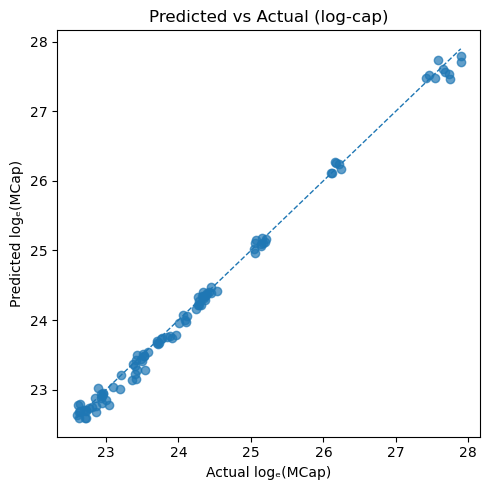

In [15]:
from autogluon.tabular import TabularPredictor


predictor = TabularPredictor.load("agent1_model")


val_pred_log = predictor.predict(val_df[features])
m = regression_metrics(val_df["Target_Log"], val_pred_log)
print(pd.Series(m).round(3))


parity_plot(val_df["Target_Log"], val_pred_log)


## Evaluation in real time data

In [18]:
def _av_get(function, **params):
    params |= {"apikey": AV_KEY, "function": function}
    url = "https://www.alphavantage.co/query"
    r = requests.get(url, params=params, timeout=10)
    r.raise_for_status()
    return r.json()


def pull_quarterly_fundamentals(ticker):
    """
    Uses the 'INCOME_STATEMENT' and 'BALANCE_SHEET' endpoints
    → returns *latest* fiscal quarter as a single-row DataFrame.
    """
    income = _av_get("INCOME_STATEMENT", symbol=ticker)
    bal = _av_get("BALANCE_SHEET", symbol=ticker)


    try:
        inc_row = income["quarterlyReports"][0]
        bal_row = bal["quarterlyReports"][0]
    except (KeyError, IndexError):
        print(f"{ticker}: Alpha Vantage fundamentals missing.")
        return pd.DataFrame()


    # Basic numeric fields (cast to float)
    def f(row, key):
        v = row.get(key)
        return np.nan if v in (None, '') else float(v)


    df = pd.DataFrame([{
        "Quarter"  : pd.to_datetime(inc_row["fiscalDateEnding"]),
        "Total_Revenue" : f(inc_row, "totalRevenue"),
        "Net_Income"  : f(inc_row, "netIncome"),
        "EPS"  : f(inc_row, "eps"),
        "Total_Debt"  : f(bal_row, "totalLiabilities"),
        "Total_Assets"  : f(bal_row, "totalAssets"),
    }])


    # Engineering identical to training:
    df["Cash_to_Debt"] = df["Total_Assets"] / df["Total_Debt"].replace(0, np.nan)
    df["NetMargin"] = df["Net_Income"]  / df["Total_Revenue"]
    df["Debt_Ratio"] = df["Total_Debt"]  / df["Total_Assets"]
    df["Asset_Turnover"] = df["Total_Revenue"] / df["Total_Assets"]


    # Place-holders for pct-change features (if model expects them)
    df[["Revenue_pctchg","EPS_pctchg","Income_Growth"]] = 0


    return df




def get_market_cap_alpha(ticker):
    """
    Alpha Vantage 'OVERVIEW' endpoint has `MarketCapitalization`
    (string, raw dollars).
    """
    ov = _av_get("OVERVIEW", symbol=ticker)
    cap = ov.get("MarketCapitalization")
    return np.nan if cap in (None, '') else float(cap)
    


In [25]:
ticker_to_name = {
    "TSLA": "Tesla",
    "F": "Ford",
    "GM": "GM",
    "RIVN": "Rivian",
    "LCID": "Lucid",
    "TM": "Toyota",
    "HMC": "Honda",
    "NIO": "NIO",
    "XPEV": "XPeng",
    "STLA": "Stellantis",
    "PSNY": "Polestar",
    "LI": "Li Auto",
    "RACE": "Ferrari",
    "LCII": "LCI Industries",
    "ALV": "Autoliv"
}


# Load the predictor
predictor = TabularPredictor.load("agent1_model")


# All columns the model expects, in the right order
features = predictor.feature_metadata.get_features()


# Company one-hot columns
unique_companies = [c[len("Company_"):] for c in features if c.startswith("Company_")]


tickers = ["TSLA", "F", "GM", "RIVN", 'LCID', 'TM', 'HMC', 'NIO', 'XPEV', 'STLA', 'PSNY', 'LI', 'RACE', 'LCII', 'ALV']


df_rows = []


for tk in tickers:
    feat_df = pull_quarterly_fundamentals(tk)
    if feat_df.empty:
        continue


    # one-hot company columns exactly as in training
    for comp in unique_companies:
        feat_df[f"Company_{comp}"] = int(ticker_to_name[tk] == comp)
    

    # keeping a copy of the date
    quarter_stamp = feat_df["Quarter"].iloc[0]
    

    # align + fill
    missing = set(features) - set(feat_df.columns)
    for col in missing:
        feat_df[col] = 0 if col.startswith("Company_") else np.nan
    

    feat_df = feat_df[features]
    

    # prediction
    y_log = predictor.predict(feat_df)
    y_cap = np.expm1(y_log)
    actual = get_market_cap_alpha(tk)
    

    df_rows.append({
        "Ticker": tk,
        "Quarter": quarter_stamp,
        "Predicted_Cap": y_cap.iloc[0],
        "Actual_Cap": actual,
        "Absolute_Error": y_cap.iloc[0] - actual,
        "% Error": (y_cap.iloc[0] - actual) / actual * 100,
    })




live_eval = pd.DataFrame(df_rows)
pd.options.display.float_format = "{:,.2f}".format
print(live_eval)


Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\predictor.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\learner.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\trainer.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetTorch_r14_BAG_L1_FULL\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\XGBoost_BAG_L1_FULL\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\WeightedEnsemble_L2_FULL\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\NeuralNetTorch_r14_BAG_L1_FULL\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\XGBoost_BAG_L1_FULL\model.pkl
Loading: C:\Users\bhall\Documents\Jupyter Notebooks\Dissertation\agent1_model\models\WeightedEnsemble_L2_FULL\model.pkl

   Ticker    Quarter      Predicted_Cap           Actual_Cap  \
0    TSLA 2025-06-30 453,210,472,448.00 1,050,174,226,000.00   
1       F 2025-03-31  55,109,599,232.00    44,855,480,000.00   
2      GM 2025-06-30  42,434,908,160.00    50,888,569,000.00   
3    RIVN 2025-03-31  33,709,932,544.00    16,507,475,000.00   
4    LCID 2025-03-31  37,011,607,552.00     8,510,225,000.00   
5      TM 2025-03-31 167,193,673,728.00   247,302,210,000.00   
6     HMC 2025-03-31  35,508,211,712.00    45,881,508,000.00   
7     NIO 2025-03-31  38,073,102,336.00    11,058,864,000.00   
8    XPEV 2025-03-31  27,615,977,472.00    18,236,852,000.00   
9    STLA 2024-12-31  43,555,303,424.00    28,044,349,000.00   
10   PSNY 2025-03-31  23,851,456,512.00     2,331,216,000.00   
11     LI 2025-03-31  29,919,907,840.00    30,178,957,000.00   
12   RACE 2025-03-31  42,181,201,920.00    92,358,828,000.00   
13   LCII 2025-03-31   3,440,699,136.00     2,486,166,000.00   
14    ALV 2025-06-30  19,620,458,496.00 